In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
from sys import float_info
from collections import namedtuple, OrderedDict
from sklearn.model_selection import ParameterGrid

import pandas as pd

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import json
import os
import random
import seaborn as sns
import pickle

import sys
sys.path.append("../..")
from networkentropy import network_energy as ne, network_energy_gradient as neg, network_utils as nu

tqdm.pandas()

In [3]:
METHODS = ['graph', 'laplacian', 'randic']
DI_METHODS = ['graph', 'directed_laplacian', 'randic']

In [4]:
DATA_PATH = "energy-gradient-centrality-data/"
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

In [5]:
def normalize_list(lizt):
    s = sum(lizt)
    part = 1/s
    return [e*part for e in lizt]

def sums_helper(length, total_sum):
    if length < 1:
        raise ValueError("Length must be positive")
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(1, total_sum):
            for permutation in sums_helper(length-1,total_sum - value):
                yield (value,) + permutation
                
def sums(factors, total_sum):
    perms = sums_helper(len(factors), total_sum)
    result = []
    for row in perms:
        norm_row = normalize_list([e*f for e, f in zip(row, factors)])
        result.append(norm_row)
    return result

In [6]:
ABG = list(sums([0.475, 0.475, 0.05], 4))

REPEATS_NO = 10

N = 300

P_PARAMS = ParameterGrid({'p': np.linspace(0.05, 0.3, 3)})
ERDOS_PARAMS = ParameterGrid({'p': np.linspace(0.05, 0.3, 3)})
HOLME_KIM_M = ParameterGrid({'m': range(2, 5)})
HOLME_KIM_P = ParameterGrid({'p': np.linspace(0.05, 0.7, 3)})
K_OUT_K = ParameterGrid({'k': range(1, 4)})
K_OUT_A = ParameterGrid({'a': range(1, 6, 2)})
PARAMS_A_B_G = [{'a': a, 'b': b, 'g': g} for a, b, g in ABG]

Gen = namedtuple('Gen', ['generator', 'params'])
NETWORKS_GENERATORS = {
    'Erdos-Renyi': Gen(lambda p: nx.erdos_renyi_graph(n=N, p=p), ERDOS_PARAMS),
    'Watts-Strogatz': Gen(lambda p: nx.watts_strogatz_graph(n=N, k=4, p=p), P_PARAMS),
    'Waxman': Gen(lambda p: nx.waxman_graph(n=N, alpha=0.5 + p, beta=0.1), P_PARAMS),
    'Holme-Kim-p.05': Gen(lambda m: nx.powerlaw_cluster_graph(n=N, m=m, p=.05), HOLME_KIM_M),
    'Holme-Kim-m2': Gen(lambda p: nx.powerlaw_cluster_graph(n=N, m=2, p=p), HOLME_KIM_P),
}

DI_NETWORK_GENERATORS = {
    'Erdos-Renyi-directed': Gen(lambda p: nx.erdos_renyi_graph(n=N, p=p, directed=True), ERDOS_PARAMS),
    'k-out-k2': Gen(lambda a: nx.DiGraph(nx.random_k_out_graph(n=N, k=3, alpha=a, self_loops=False)), K_OUT_A),
    'k-out-alpha1': Gen(lambda k: nx.DiGraph(nx.random_k_out_graph(n=N, k=k, alpha=1, self_loops=False)), K_OUT_K),
    'scale-free': Gen(lambda a, b, g: nx.DiGraph(nx.scale_free_graph(alpha=a, beta=b, gamma=g, n=N)), PARAMS_A_B_G)
}

In [7]:
CENTRALITIES = {
    'gradient_centrality-relu': lambda g, method: neg.get_energy_gradient_centrality(g, method=method, activation='relu'),
    'gradient_centrality-elu': lambda g, method: neg.get_energy_gradient_centrality(g, method=method, activation='elu'),
}
GRAD_CENTRALITY_RELU, GRAD_CENTRALITY_ELU = CENTRALITIES.keys()

In [8]:
def paramgrid_to_list(param_grid):
    return [next(iter(e.values())) for e in list(param_grid)]

In [9]:
def get_largest_connected_component(g):
    return nx.subgraph(g, max(nx.connected_components(g.to_undirected()), key=len))

In [10]:
def create_graphs(generators: dict, repeats_num):
    graphs = []
    for name, (generator, params) in tqdm(list(generators.items())):
        for i, params_row in tqdm(list(enumerate(params))):
            for reepat_no in range(repeats_num):
                g = get_largest_connected_component(generator(**params_row))
                row = {**params_row, 'generator': name, 'params_num': i, 'g': g, 'repeat_no': reepat_no,
                       'id': f'{name} {params_row} {reepat_no}'}
                graphs.append(row)
    return pd.DataFrame(graphs)

In [11]:
CentralityEntry = namedtuple('CentralityEntry', ['method', 'centrality', 'node', 'value'])

def calculate_gradient_centrality(graphs_df: pd.DataFrame, centralities, methods) -> pd.DataFrame:
    results = []
    for _, row in tqdm(list(graphs_df.iterrows())):
        g = row['g']
        for (method, (c_name, c_method)) in itertools.product(methods, centralities.items()):
            centrality_result = c_method(g, method)
            for k, v in centrality_result.items():
                results.append(OrderedDict(list(row.items()) + list(CentralityEntry(method, c_name, k, v)._asdict().items())))
    return pd.DataFrame(results)

In [12]:
def flatten_centrality_df(centrality_df: pd.DataFrame, methods, additional_attrs = []):
    centrality_attrs = methods
    if len(additional_attrs) <= 0:
        additional_attrs = list(set(centrality_df.columns).difference(centrality_attrs))
    flatten_rows = []
    for _, row in centrality_df.loc[:, centrality_attrs + additional_attrs].iterrows():
        additional_attrs_values = [(attr, val) for attr, val in zip(additional_attrs, row[len(centrality_attrs):])]
        for name, centrality in zip(centrality_attrs, row):
            if centrality:
                for node, value in centrality.items():
                    flatten_rows.append(OrderedDict(additional_attrs_values +
                                                    [('node', node), ('method', name), ('gradient_centrality', value)]))
    return pd.DataFrame(flatten_rows)

In [13]:
def plot_distributions(data, col, row, title, file_name, hue=None, hue_order=None, add_legend=True, adjust_top=0.92, hist=True):
    sns.reset_orig()
    sns.set(font_scale=1.3)
    g = sns.FacetGrid(data, col=col, row=row, hue=hue, hue_order=hue_order,
                  sharex=False, sharey=False,
                  height=3, aspect=1.5, legend_out=False, margin_titles=True)
    g = g.map(sns.distplot, "value", kde_kws={"lw": 3}, hist=hist)
    if add_legend:
        g = g.add_legend()
    g.fig.subplots_adjust(top=adjust_top)
    g.fig.suptitle(title, fontsize=16)
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    g.savefig(f"{PLOTS_PATH}{file_name}")
    return g

In [14]:
PLOTS_PATH = "energy-gradient-centrality-plots/"
if not os.path.exists(PLOTS_PATH):
    os.mkdir(PLOTS_PATH)

In [15]:
graphs_df = create_graphs(NETWORKS_GENERATORS, REPEATS_NO)
gradient_centrality_df = calculate_gradient_centrality(graphs_df, CENTRALITIES, METHODS)

KeyboardInterrupt: 

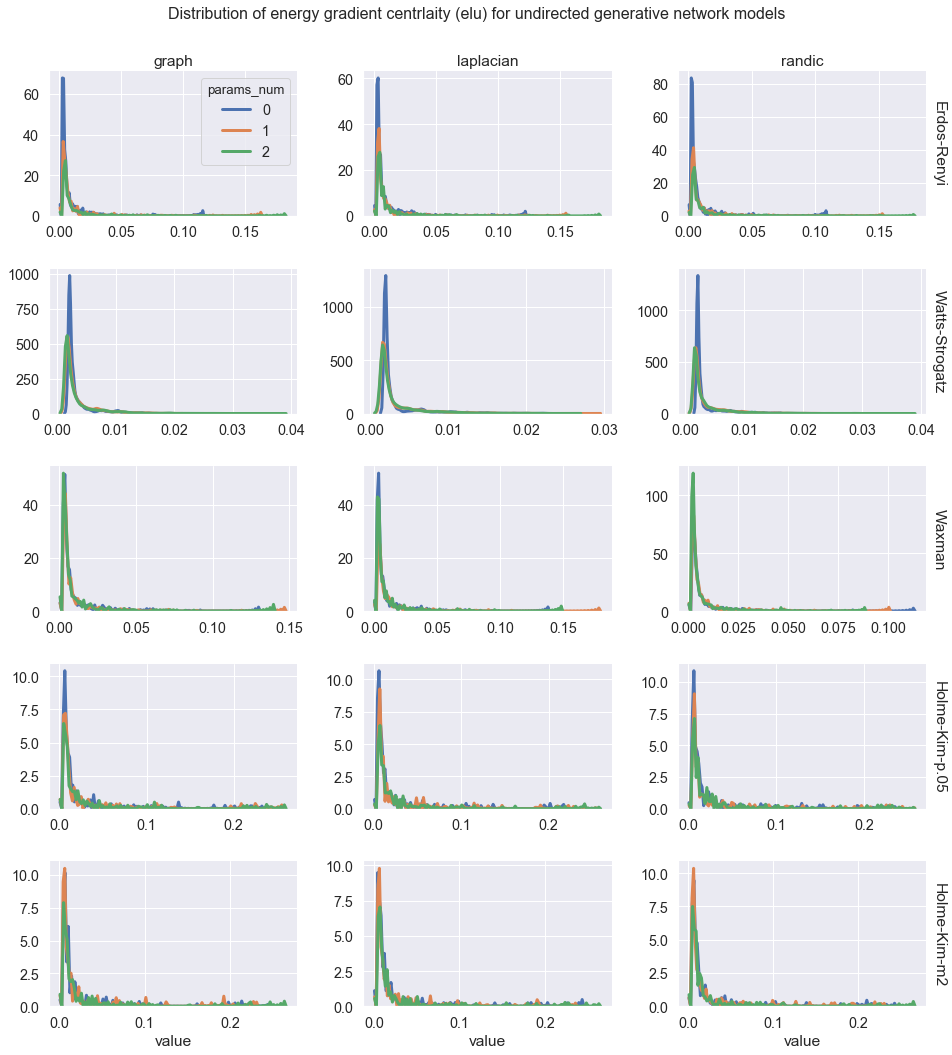

In [26]:
plot_distributions(gradient_centrality_df.query('centrality==@GRAD_CENTRALITY_RELU'), col='method', row='generator', hue='params_num', hist=False,
                   title='Distribution of energy gradient centrlaity (elu) for undirected generative network models',
                   file_name='energy-gradient-centrality-relu-undirected-dist.pdf')

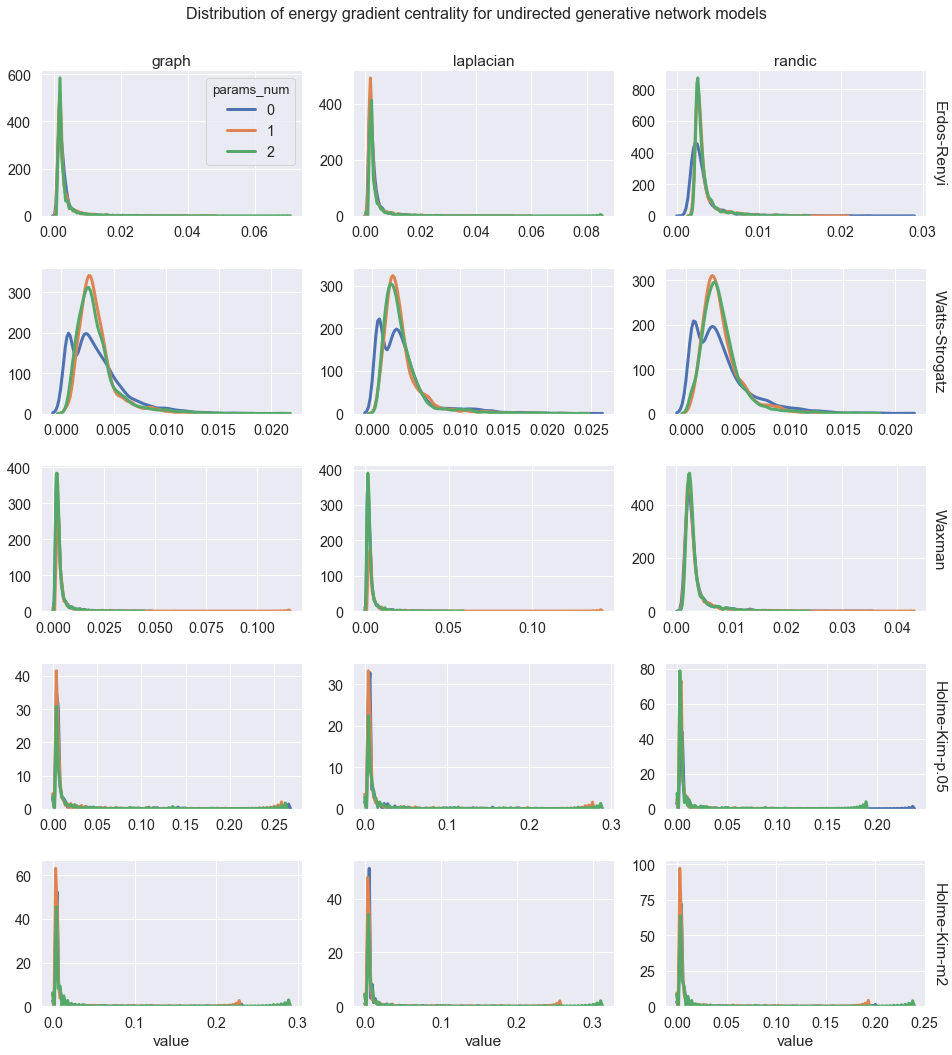

In [27]:
plot_distributions(gradient_centrality_df.query('centrality==@GRAD_CENTRALITY_ELU'), col='method', row='generator', hue='params_num', hist=False,
                   title='Distribution of energy gradient centrality for undirected generative network models',
                   file_name='energy-gradient-centrality-elu-undirected-dist.pdf')

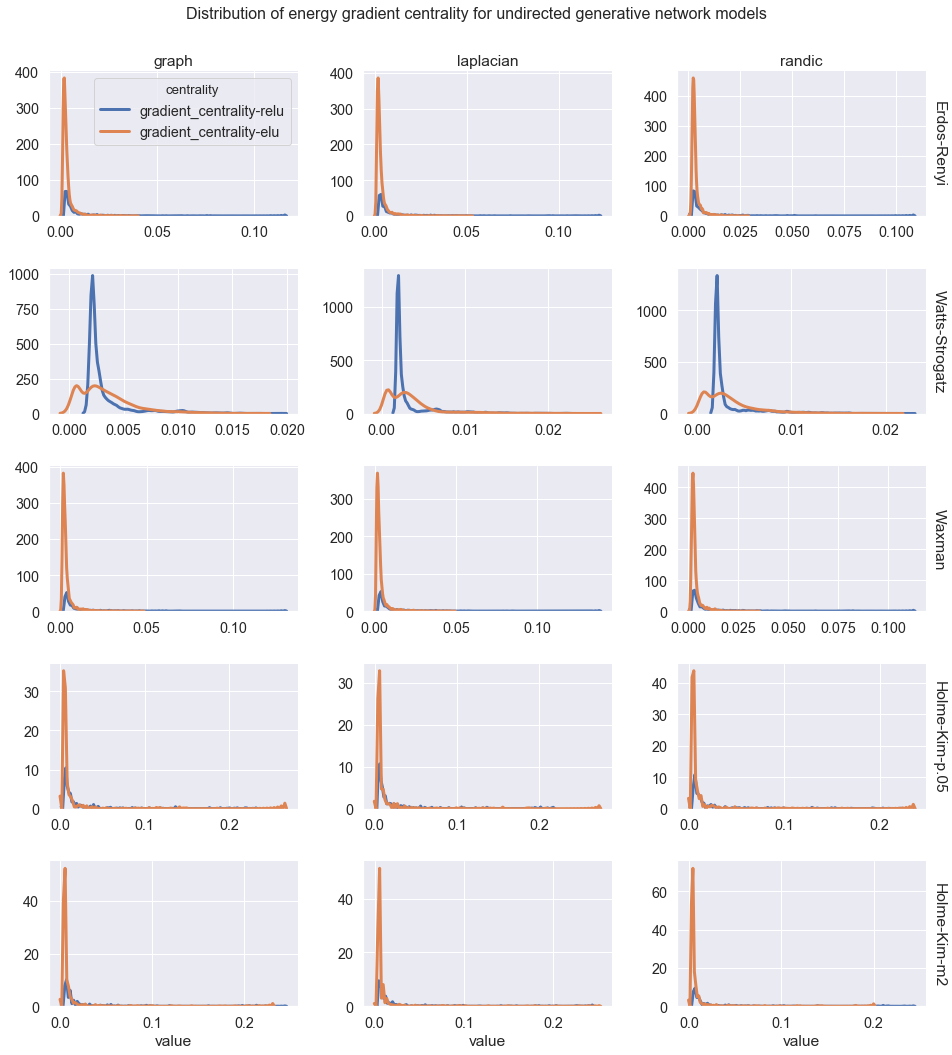

In [28]:
plot_distributions(gradient_centrality_df.query('params_num==0'), col='method', row='generator', hue='centrality', hist=False,
                   title='Distribution of energy gradient centrality for undirected generative network models',
                   file_name='energy-gradient-centrality-param0-undirected-dist.pdf')

In [29]:
di_graphs_df = create_graphs(DI_NETWORK_GENERATORS, REPEATS_NO)
di_gradient_centrality_df = calculate_gradient_centrality(di_graphs_df, centralities=CENTRALITIES, methods=DI_METHODS)

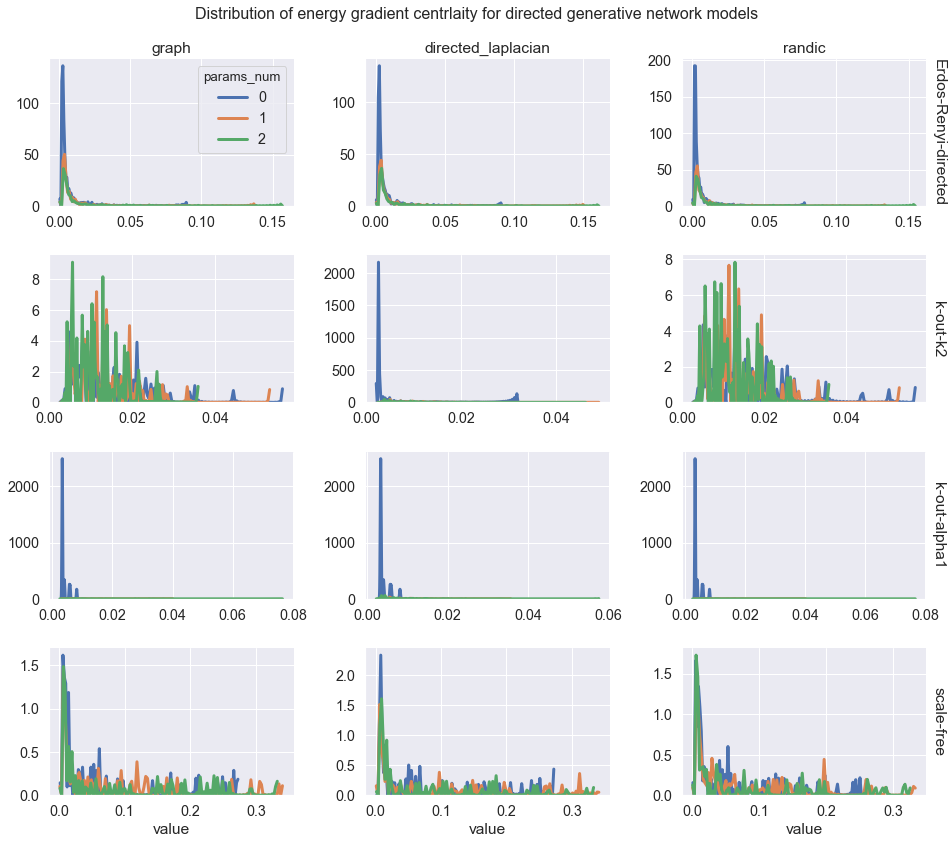

In [46]:
plot_distributions(di_gradient_centrality_df.query('centrality==@GRAD_CENTRALITY_RELU'), col='method', row='generator', hue='params_num', hist=False,
                   title='Distribution of energy gradient centrlaity for directed generative network models',
                   file_name='energy-gradient-centrality-relu-directed-dist.pdf')

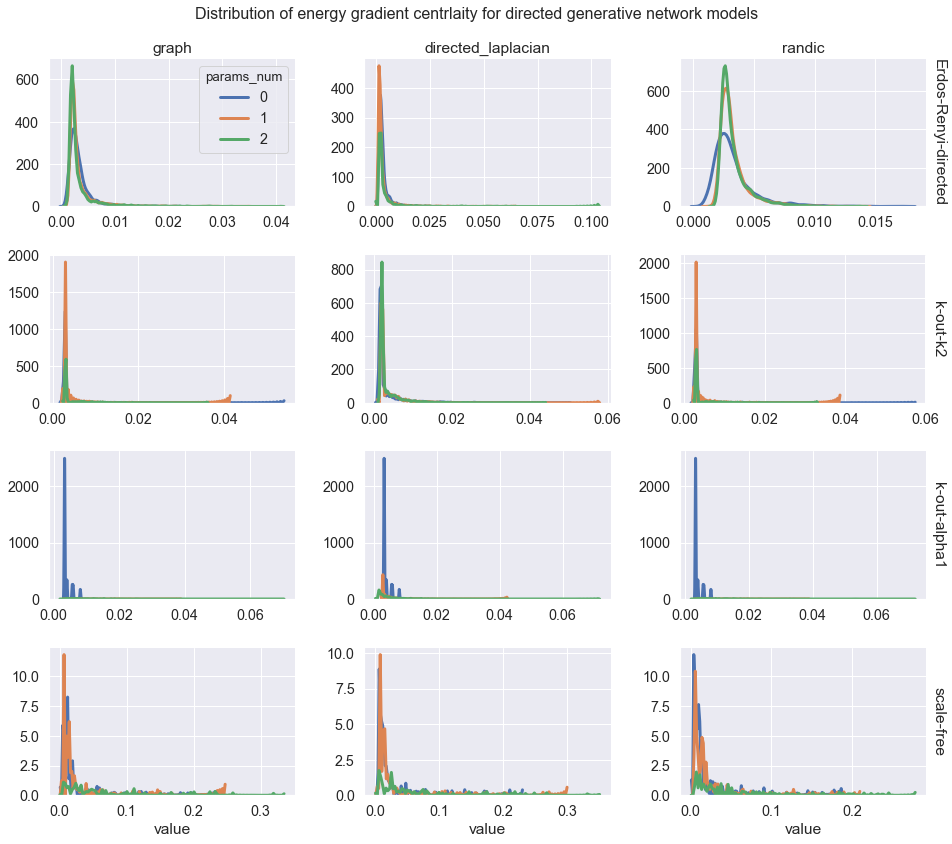

In [47]:
plot_distributions(di_gradient_centrality_df.query('centrality==@GRAD_CENTRALITY_ELU'), col='method', row='generator', hue='params_num', hist=False,
                   title='Distribution of energy gradient centrlaity for directed generative network models',
                   file_name='energy-gradient-centrality-elu-directed-dist.pdf')

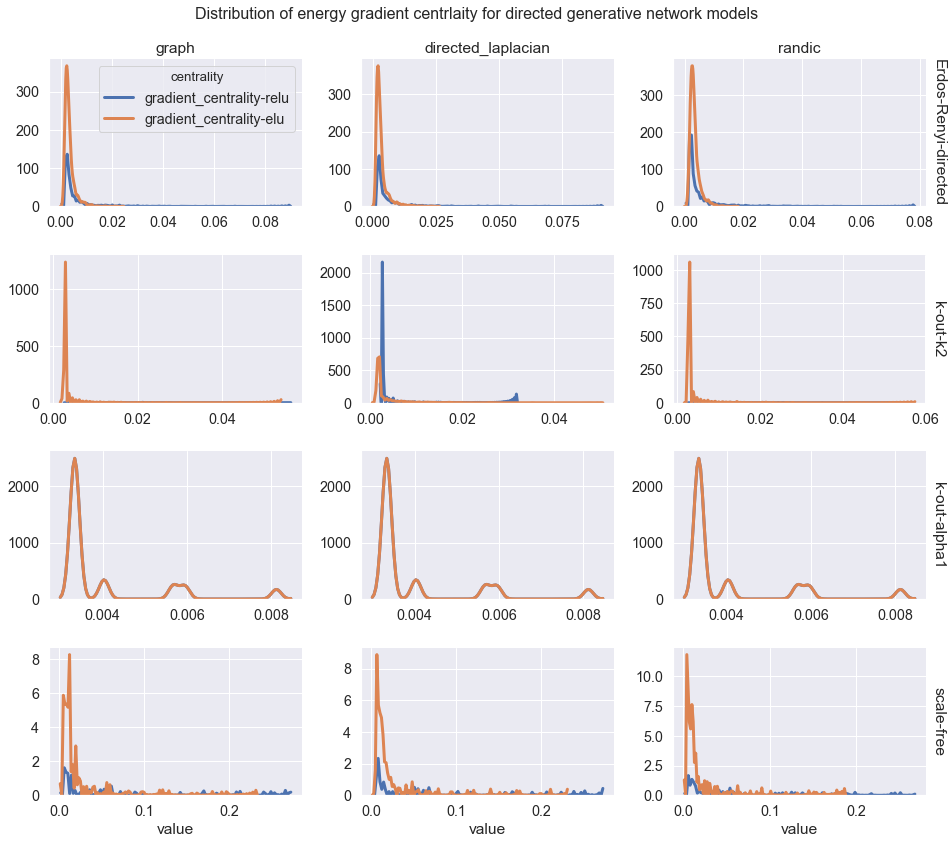

In [48]:
plot_distributions(di_gradient_centrality_df.query('params_num==0'), col='method', row='generator', hue='centrality', hist=False,
                   title='Distribution of energy gradient centrlaity for directed generative network models',
                   file_name='energy-gradient-centrality-param0-directed-dist.pdf')

In [16]:
datasets = nu.create_datasets('konect.uni')
filtered_datasets = datasets.filter(directed=False, min_size=200, max_size=1500, max_density=0.1)
empirical_networks_df = filtered_datasets.download_and_build_networks().rename(columns={'graph': 'g'})
largest_component_df = empirical_networks_df.progress_apply(lambda s: get_largest_connected_component(s['g']), axis=1)
largest_component_n_df = largest_component_df.progress_apply(lambda g: nx.number_of_nodes(g))
print(largest_component_n_df)
empirical_networks_df = empirical_networks_df.assign(g=largest_component_df)
empirical_networks_df = empirical_networks_df.assign(real_num_nodes=largest_component_n_df)
empirical_networks_df = empirical_networks_df.query('real_num_nodes <= 1500')

100% [................................................................................] 7954 / 7954


27       453
34       823
44       829
75      1039
147      161
192     1133
193    34414
195      791
dtype: int64


In [17]:
empirical_gradients_centrality_df = calculate_gradient_centrality(empirical_networks_df, centralities=CENTRALITIES, methods=METHODS)

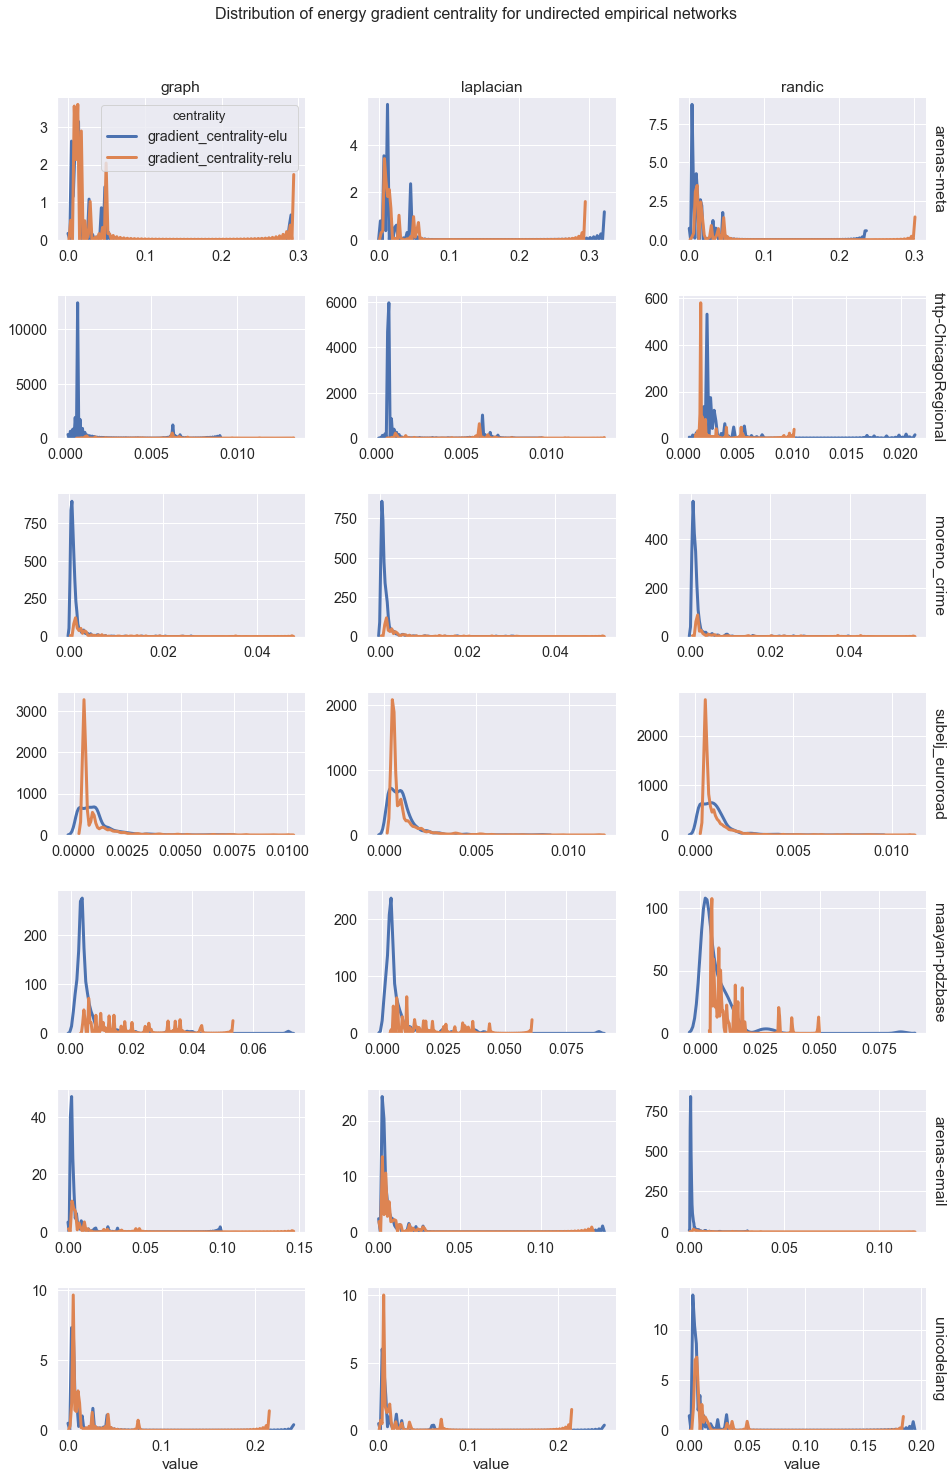

In [18]:
plot_distributions(empirical_gradients_centrality_df, col='method', row='name', hue='centrality', hue_order=list(CENTRALITIES.keys())[::-1], hist=False,
                   title='Distribution of energy gradient centrality for undirected empirical networks',
                   file_name='energy-gradient-centrality-undirected-empirical-dist.pdf')

In [19]:
di_filtered_datasets = datasets.filter(directed=True, min_size=200, max_size=1500, max_density=0.1)
di_empirical_networks_df = di_filtered_datasets.download_and_build_networks().rename(columns={'graph': 'g'})
largest_component_df = di_empirical_networks_df.progress_apply(lambda s: get_largest_connected_component(s['g']), axis=1)
largest_component_n_df = largest_component_df.progress_apply(lambda g: nx.number_of_nodes(g))
print(largest_component_n_df)
di_empirical_networks_df = di_empirical_networks_df.assign(g=largest_component_df)
di_empirical_networks_df = di_empirical_networks_df.assign(real_num_nodes=largest_component_n_df)
di_empirical_networks_df = di_empirical_networks_df.query('real_num_nodes <= 1500')

100% [................................................................................] 9482 / 9482


4      1226
23     1222
149     117
160     217
dtype: int64


In [20]:
di_empirical_gradients_centrality_df = calculate_gradient_centrality(di_empirical_networks_df, centralities=CENTRALITIES, methods=DI_METHODS)

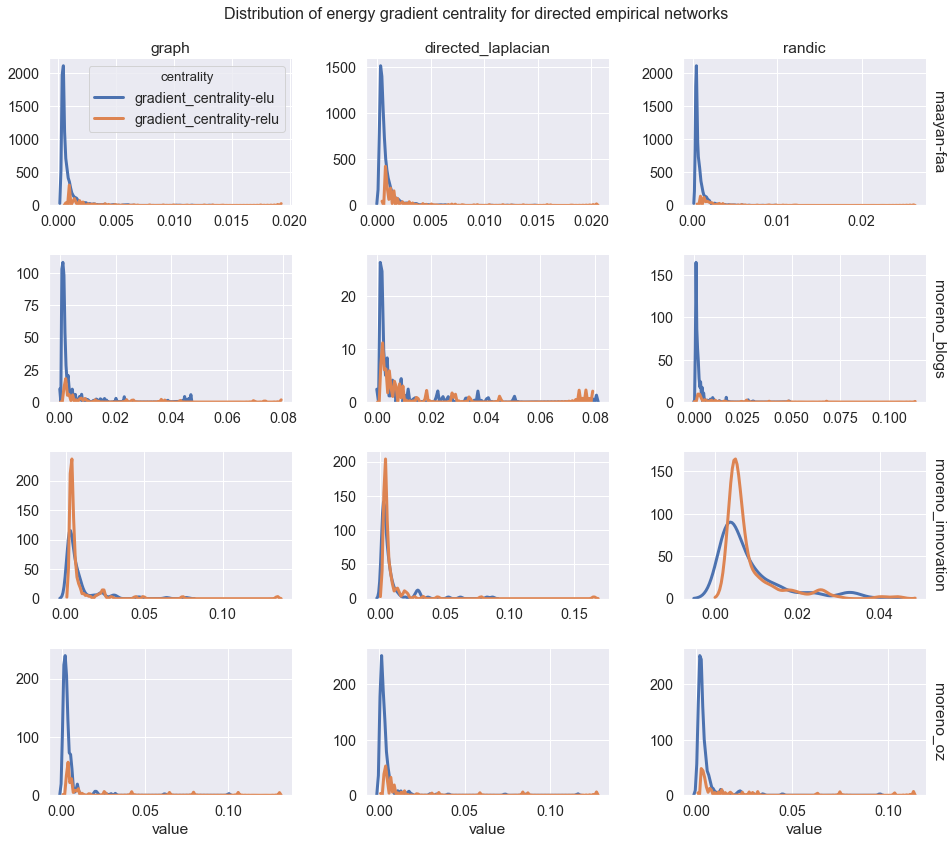

In [21]:
plot_distributions(di_empirical_gradients_centrality_df, col='method', row='name', hue='centrality', hue_order=list(CENTRALITIES.keys())[::-1], hist=False,
                   title='Distribution of energy gradient centrality for directed empirical networks',
                   file_name='energy-gradient-centrality-directed-empirical-dist.pdf')

In [15]:
def normalize_list(lizt):
    s = sum(lizt)
    part = 1/s
    return [e*part for e in lizt]

def sums_helper(length, total_sum):
    if length < 1:
        raise ValueError("Length must be positive")
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(1, total_sum):
            for permutation in sums_helper(length-1,total_sum - value):
                yield (value,) + permutation
                
def sums(factors, total_sum):
    perms = sums_helper(len(factors), total_sum)
    result = []
    for row in perms:
        norm_row = normalize_list([e*f for e, f in zip(row, factors)])
        result.append(norm_row)
    return result

In [16]:
ABG = list(sums([0.475, 0.475, 0.05], 15))
length = len(ABG)

In [17]:
REPEATS_NO = 10
N = 300

P_PARAMS = ParameterGrid({'p': np.linspace(0.01, 0.3, length)})
ERDOS_PARAMS = ParameterGrid({'p': np.linspace(0.01, 0.3, length)})
HOLME_KIM_P = ParameterGrid({'p': np.linspace(0.01, 0.7, length)})
K_OUT_A = ParameterGrid({'a': np.linspace(0, 20, length)})
PARAMS_A_B_G = [{'a': a, 'b': b, 'g': g} for a, b, g in ABG]

Gen = namedtuple('Gen', ['generator', 'params'])
NETWORKS_GENERATORS = {
    'Erdos-Renyi': Gen(lambda p: nx.erdos_renyi_graph(n=N, p=p), ERDOS_PARAMS),
    'Watts-Strogatz': Gen(lambda p: nx.watts_strogatz_graph(n=N, k=4, p=p), P_PARAMS),
    'Waxman': Gen(lambda p: nx.waxman_graph(n=N, alpha=0.5 + p, beta=0.1), P_PARAMS),
    'Holme-Kim-m2': Gen(lambda p: nx.powerlaw_cluster_graph(n=N, m=2, p=p), HOLME_KIM_P),
}

DI_NETWORK_GENERATORS = {
    'Erdos-Renyi-directed': Gen(lambda p: nx.erdos_renyi_graph(n=N, p=p, directed=True), ERDOS_PARAMS),
    'k-out-k2': Gen(lambda a: nx.DiGraph(nx.random_k_out_graph(n=N, k=2, alpha=a, self_loops=False)), K_OUT_A),
    'k-out-k5': Gen(lambda a: nx.DiGraph(nx.random_k_out_graph(n=N, k=5, alpha=a, self_loops=False)), K_OUT_A),
    'scale-free': Gen(lambda a, b, g: nx.DiGraph(nx.scale_free_graph(alpha=a, beta=b, gamma=g, n=N)), PARAMS_A_B_G)
}

GRADIENT_CENTRALITY_PARAMS = ParameterGrid({'m': METHODS, 'a': ['relu', 'elu']})
DI_GRADIENT_CENTRALITY_PARAMS = ParameterGrid({'m': DI_METHODS, 'a': ['relu', 'elu']})

CORR_CENTRALITIES = {
    'eigencentrality': nx.pagerank,
    'betweenness': nx.betweenness_centrality,
    'closeness': nx.closeness_centrality,
    'degree': nx.degree_centrality,
    'gradient_centrality-graph-relu': lambda g: neg.get_energy_gradient_centrality(g, method='graph', activation='relu'),
    'gradient_centrality-laplacian-relu': lambda g: neg.get_energy_gradient_centrality(g, method='laplacian', activation='relu'),
    'gradient_centrality-randic-relu': lambda g: neg.get_energy_gradient_centrality(g, method='randic', activation='relu'),
    'gradient_centrality-graph-elu': lambda g: neg.get_energy_gradient_centrality(g, method='graph', activation='elu'),
    'gradient_centrality-laplacian-elu': lambda g: neg.get_energy_gradient_centrality(g, method='laplacian', activation='elu'),
    'gradient_centrality-randic-elu': lambda g: neg.get_energy_gradient_centrality(g, method='randic', activation='elu'),
}

DI_CORR_CENTRALITIES = {
    'eigencentrality': nx.pagerank,
    'betweenness': nx.betweenness_centrality,
    'closeness': nx.closeness_centrality,
    'degree': nx.degree_centrality,
    'gradient_centrality-graph-relu': lambda g: neg.get_energy_gradient_centrality(g, method='graph', activation='relu'),
    'gradient_centrality-directed_laplacian-relu': lambda g: neg.get_energy_gradient_centrality(g, method='directed_laplacian', activation='relu'),
    'gradient_centrality-randic-relu': lambda g: neg.get_energy_gradient_centrality(g, method='randic', activation='relu'),
    'gradient_centrality-graph-elu': lambda g: neg.get_energy_gradient_centrality(g, method='graph', activation='elu'),
    'gradient_centrality-directed_laplacian-elu': lambda g: neg.get_energy_gradient_centrality(g, method='directed_laplacian', activation='elu'),
    'gradient_centrality-randic-elu': lambda g: neg.get_energy_gradient_centrality(g, method='randic', activation='elu'),
}

GRADIENT_CENTRALITIES = [f"gradient_centrality-{e['m']}-{e['a']}" for e in GRADIENT_CENTRALITY_PARAMS]
DI_GRADIENT_CENTRALITIES = [f"gradient_centrality-{e['m']}-{e['a']}" for e in DI_GRADIENT_CENTRALITY_PARAMS]

In [18]:
CorrCentralityEntry = namedtuple('CorrCentralityEntry', ['centrality', 'node', 'value'])

def calculate_centrality(graphs_df: pd.DataFrame, centralities) -> pd.DataFrame:
    results = []
    for _, row in tqdm(list(graphs_df.iterrows())):
        g = row['g']
        for c_name, c_method in centralities.items():
            centrality_result = c_method(g)
            for k, v in centrality_result.items():
                results.append(OrderedDict(list(row.items()) + list(CorrCentralityEntry(c_name, k, v)._asdict().items())))
    return pd.DataFrame(results)

In [19]:
CorrGraphCentralityEntry = namedtuple('CorrCentralityEntry', ['generator', 'params_num', 'repeat_no', 'params', 'centrality', 'node', 'value'])

def create_graphs_and_calculate_gradient_centrality(generators: dict, repeats_num, centralities):
    results = []
    for name, (generator, params) in tqdm(list(generators.items())):
        for i, params_row in tqdm(list(enumerate(params))):
            for reepat_no in range(repeats_num):
                g = get_largest_connected_component(generator(**params_row))
                
                for c_name, c_method in centralities.items():
                    centrality_result = c_method(g)
                    for k, v in centrality_result.items():
                        results.append(CorrGraphCentralityEntry(generator, i, reepat_no, params_row, c_name, k, v)._asdict())
                        
    return pd.DataFrame(results)

In [ ]:
corr_graphs_df = create_graphs(NETWORKS_GENERATORS, REPEATS_NO)

corr_gradient_centrality_df = calculate_centrality(corr_graphs_df, centralities=CORR_CENTRALITIES)

In [43]:
pivoted_corr_gradient_centrality_df = corr_gradient_centrality_df.pivot_table(index=['id', 'generator', 'node', 'params_num', 'repeat_no'], columns='centrality', values='value').reset_index()

correlations_df = pivoted_corr_gradient_centrality_df.loc[:, ['generator', 'params_num'] + list(CORR_CENTRALITIES.keys())] \
.groupby(['generator', 'params_num']).corr().reset_index()

correlations_df = correlations_df.rename(columns={'centrality': 'centrality2'})
id_vars = ['generator', 'params_num', 'centrality2']
value_vars = list(set(correlations_df.columns).difference(id_vars))
melted_correlations_df = correlations_df.melt(id_vars=id_vars, value_vars=value_vars).query('centrality2 in @GRADIENT_CENTRALITIES and centrality not in @GRADIENT_CENTRALITIES')

In [50]:
with open(f"{DATA_PATH}corr-gradient-centrality-undirected.dat", "wb") as f:
    pickle.dump(corr_gradient_centrality_df, f)

In [41]:
pivoted_corr_gradient_centrality_df.head()

centrality,id,generator,node,params_num,repeat_no,betweenness,closeness,degree,eigencentrality,gradient_centrality-graph-elu,gradient_centrality-graph-relu,gradient_centrality-laplacian-elu,gradient_centrality-laplacian-relu,gradient_centrality-randic-elu,gradient_centrality-randic-relu
0,Erdos-Renyi {'p': 0.013222222222222222} 0,Erdos-Renyi,0,1,0,0.005255,0.264996,0.010135,0.002266,0.003840,0.001106,0.003477,0.001323,0.003571,0.002209
1,Erdos-Renyi {'p': 0.013222222222222222} 0,Erdos-Renyi,1,1,0,0.000000,0.212797,0.003378,0.001195,0.000699,0.001106,0.000633,0.001323,0.001176,0.001397
2,Erdos-Renyi {'p': 0.013222222222222222} 0,Erdos-Renyi,2,1,0,0.001896,0.265709,0.010135,0.002226,0.007344,0.001213,0.006138,0.001323,0.006780,0.001822
3,Erdos-Renyi {'p': 0.013222222222222222} 0,Erdos-Renyi,3,1,0,0.000000,0.188655,0.003378,0.001313,0.001026,0.001106,0.000716,0.001323,0.000988,0.001397
4,Erdos-Renyi {'p': 0.013222222222222222} 0,Erdos-Renyi,4,1,0,0.002704,0.230530,0.010135,0.002457,0.002114,0.001106,0.002034,0.001323,0.001184,0.001754


In [28]:
CORR_PLOTS_PATH = "energy-gradient-centrality-correlations/"
if not os.path.exists(CORR_PLOTS_PATH):
    os.mkdir(CORR_PLOTS_PATH)

In [20]:
def plot_correlations(data, col, row, title, file_name, hue=None, add_legend=True, adjust_top=0.92):
    sns.reset_orig()
    sns.set(font_scale=1.3)
    g = sns.FacetGrid(data, col=col, row=row, hue=hue, 
                  sharex=False, sharey=False,
                  height=3, aspect=1.5, legend_out=True, margin_titles=True)
    g = g.map(sns.lineplot, "params_num", "value")
    if add_legend:
        g = g.add_legend()
    g.fig.subplots_adjust(top=adjust_top)
    g.fig.suptitle(title, fontsize=16)
    [plt.setp(ax.texts, text="") for ax in g.axes.flat]
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    g.savefig(f"{CORR_PLOTS_PATH}{file_name}")
    return g

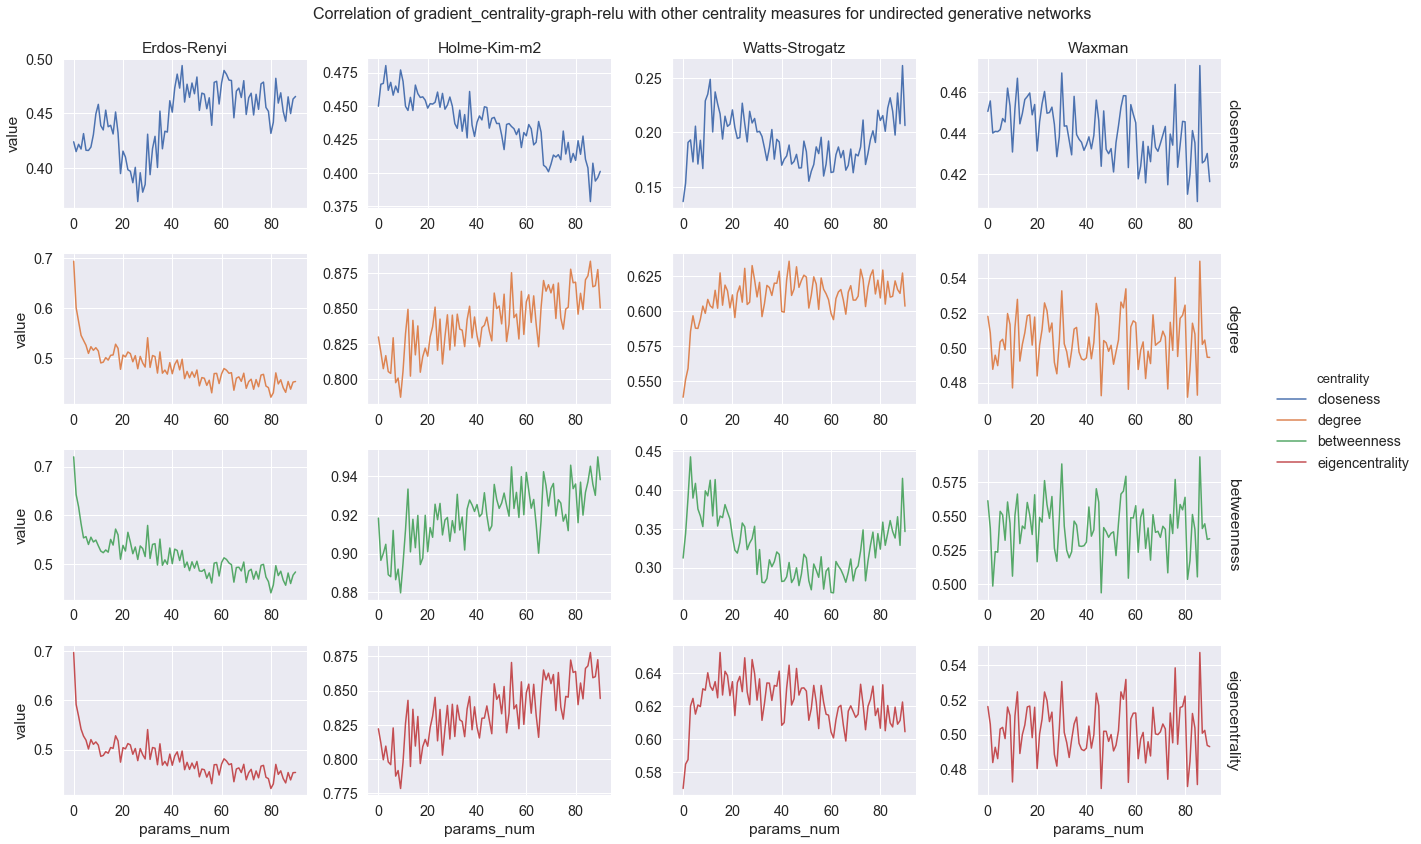

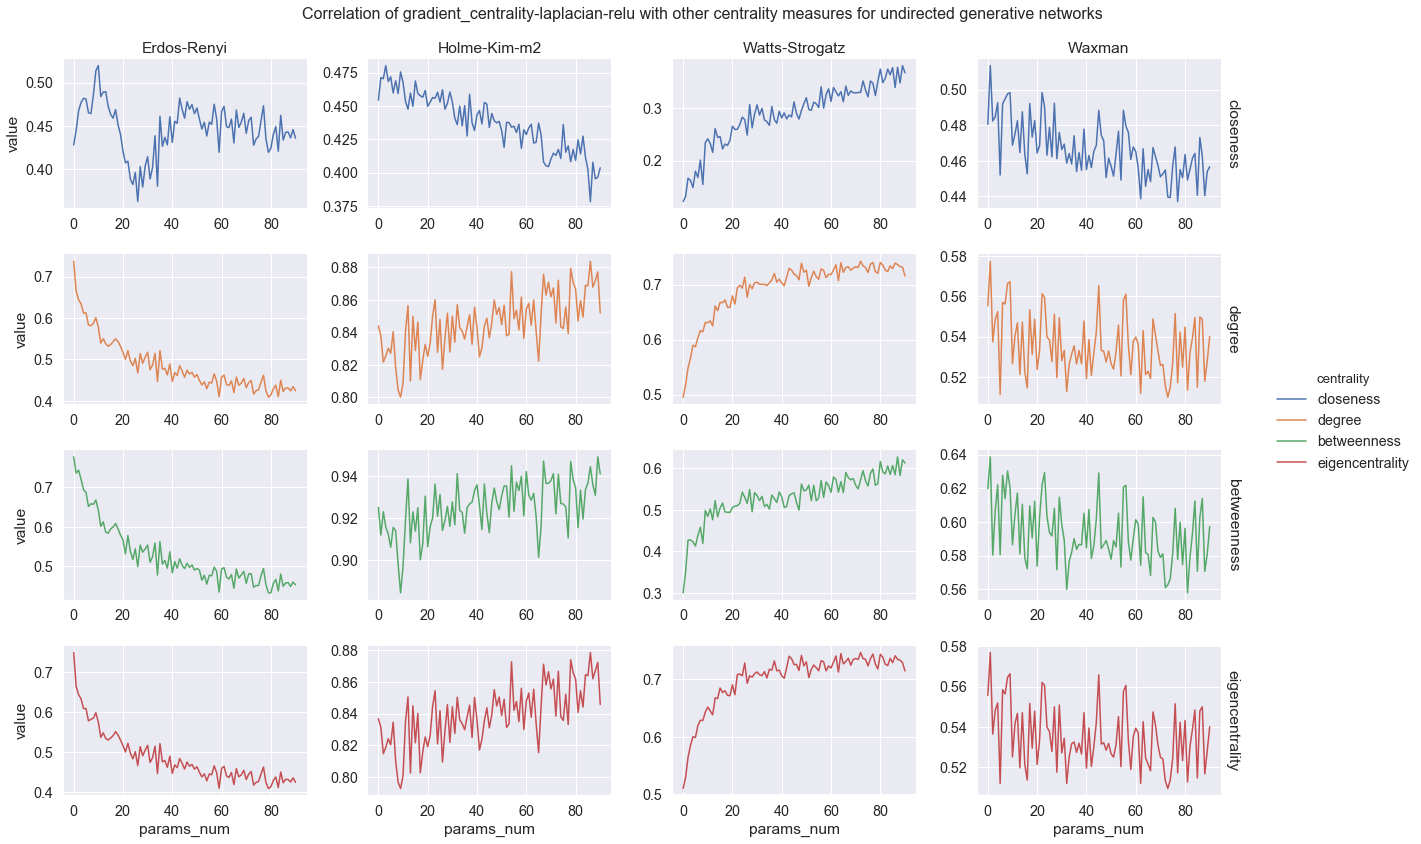

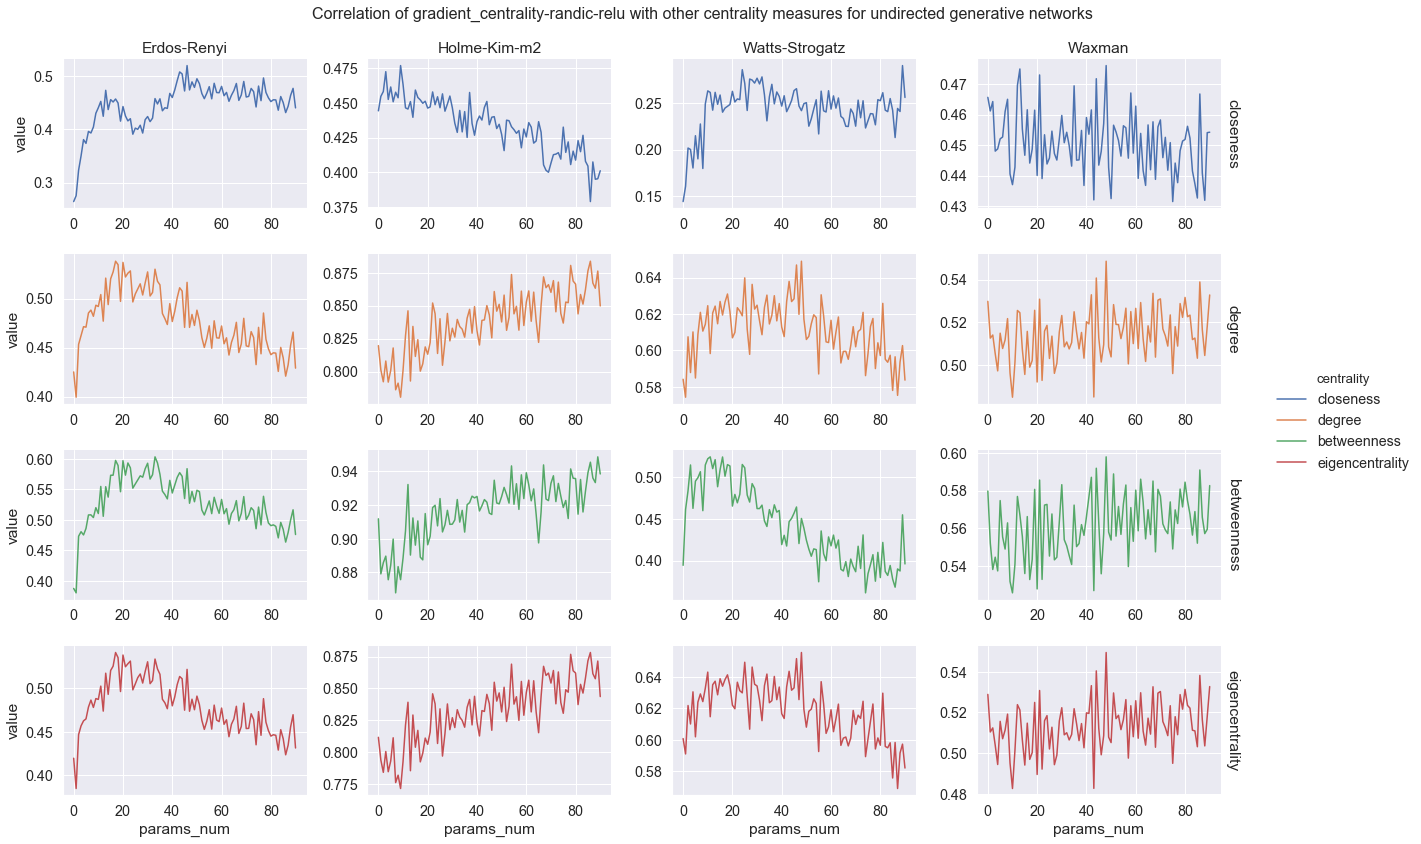

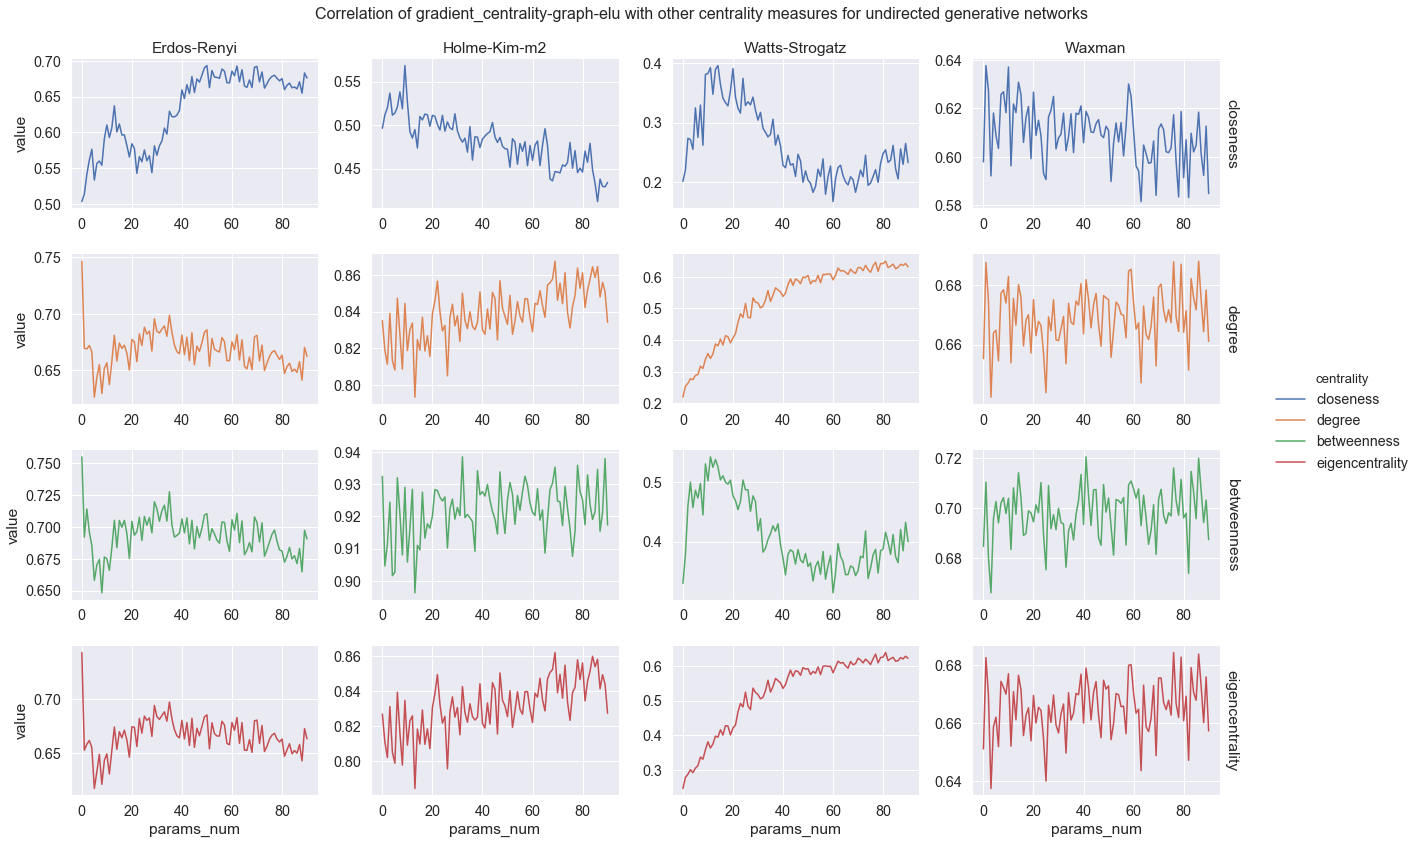

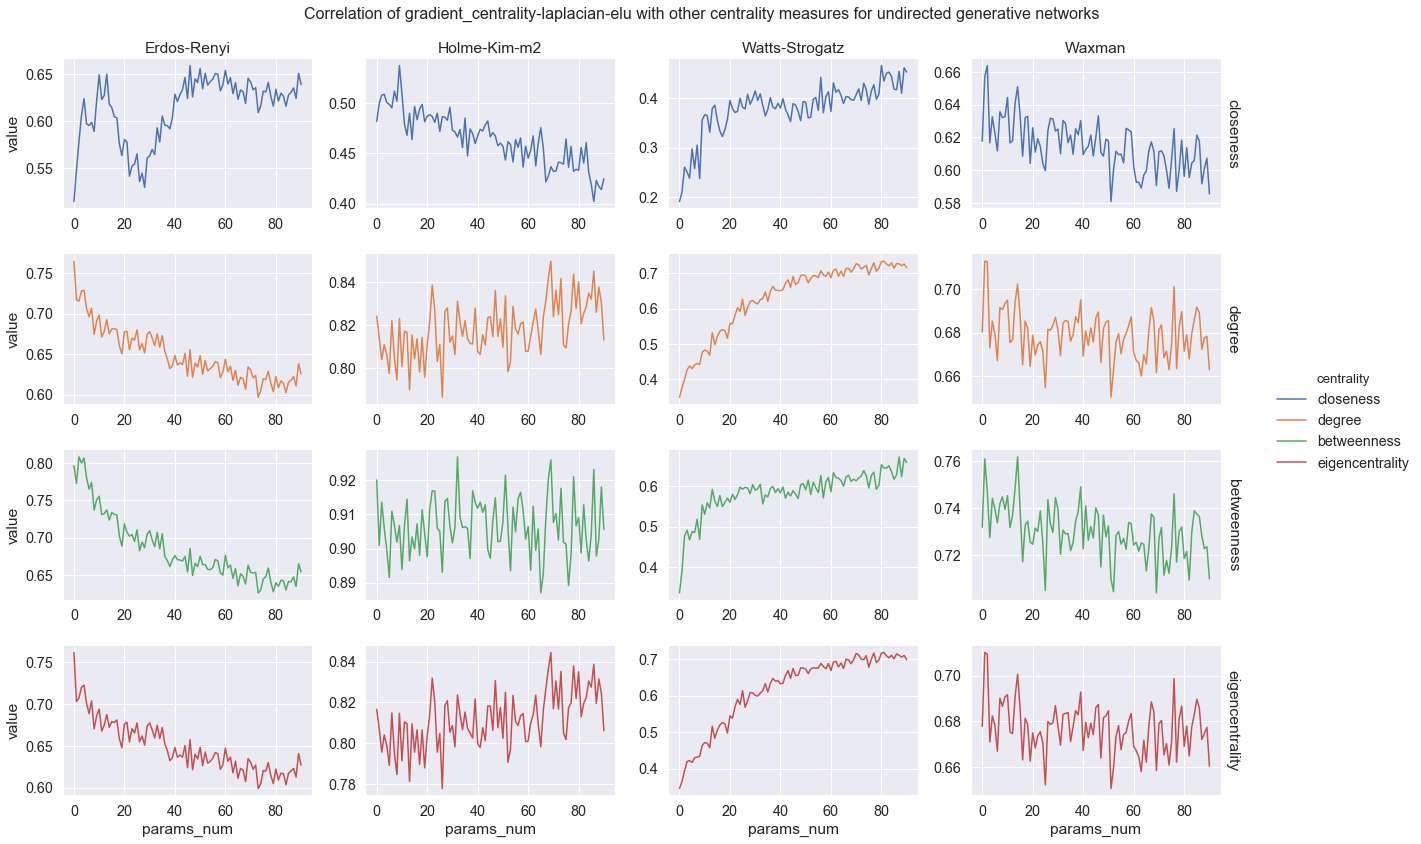

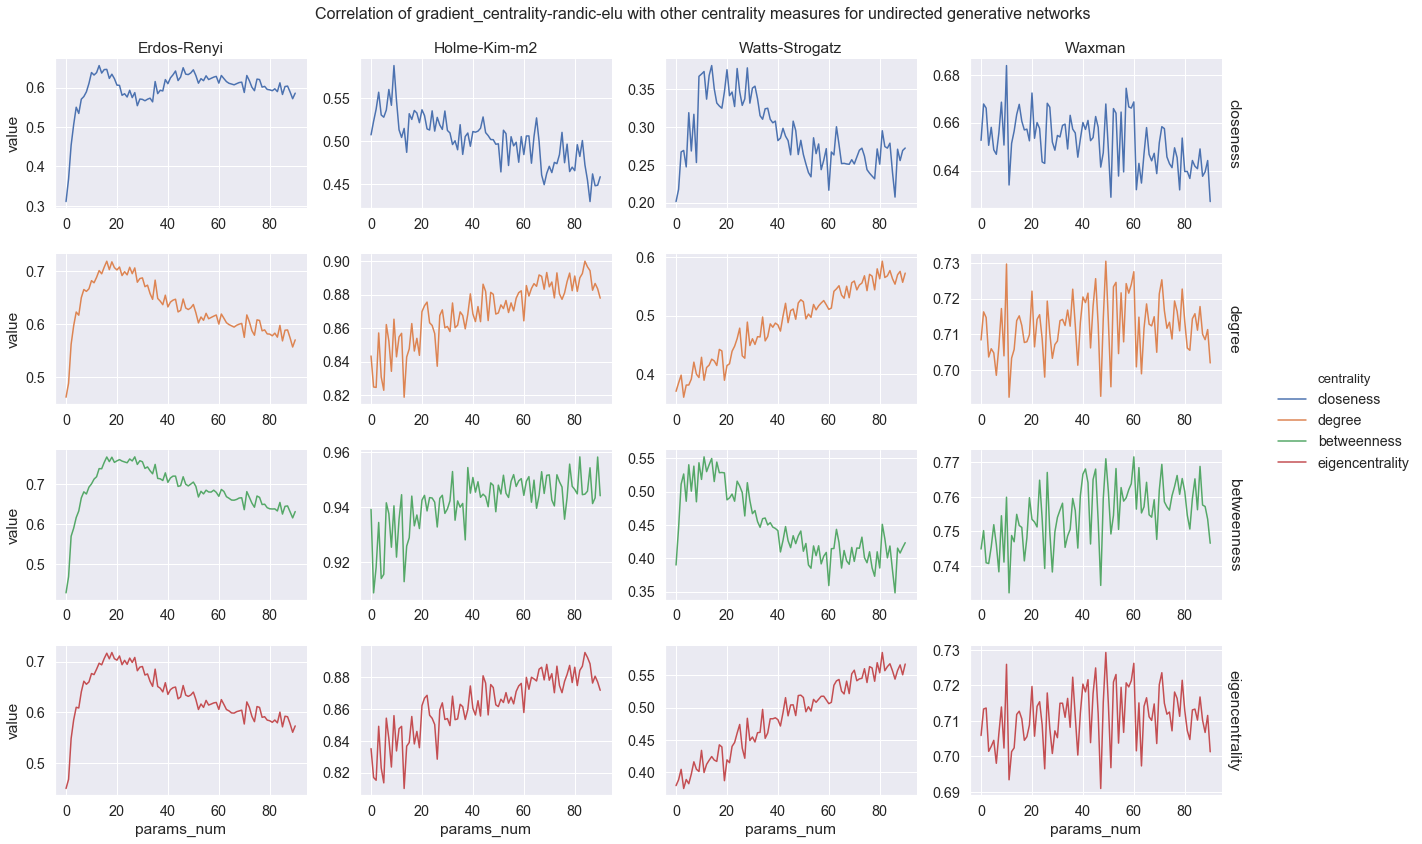

In [30]:
for centrality in GRADIENT_CENTRALITIES:
    plot_correlations(melted_correlations_df.query("centrality2 == @centrality"), col='generator', row='centrality', hue='centrality',
                     title=f"Correlation of {centrality} with other centrality measures for undirected generative networks",
                     file_name=f"correlation-undirected-{centrality}.pdf")

In [54]:
del corr_gradient_centrality_df
del pivoted_corr_gradient_centrality_df

In [56]:
di_corr_graphs_df = create_graphs(DI_NETWORK_GENERATORS, repeats_num=4)

di_corr_gradient_centrality_df = calculate_centrality(di_corr_graphs_df, centralities=DI_CORR_CENTRALITIES)

di_pivoted_corr_gradient_centrality_df = di_corr_gradient_centrality_df.pivot_table(index=['id', 'generator', 'node', 'params_num'], columns='centrality', values='value').reset_index()

di_correlations_df = di_pivoted_corr_gradient_centrality_df.loc[:, ['generator', 'params_num'] + list(DI_CORR_CENTRALITIES.keys())] \
.groupby(['generator', 'params_num']).corr().reset_index()

di_correlations_df = di_correlations_df.rename(columns={'centrality': 'centrality2'})
id_vars = ['generator', 'params_num', 'centrality2']
value_vars = list(set(di_correlations_df.columns).difference(id_vars))

di_melted_correlations_df = di_correlations_df.melt(id_vars=id_vars, value_vars=value_vars).query('centrality2 in @DI_GRADIENT_CENTRALITIES and centrality not in @DI_GRADIENT_CENTRALITIES')

KeyboardInterrupt: 

In [ ]:
di_corr_gradient_centrality_df = create_graphs_and_calculate_gradient_centrality(generators=DI_NETWORK_GENERATORS, repeats_num=REPEATS_NO, centralities=DI_CORR_CENTRALITIES)

di_pivoted_corr_gradient_centrality_df = di_corr_gradient_centrality_df.pivot_table(index=['id', 'generator', 'node', 'params_num'], columns='centrality', values='value').reset_index()

di_correlations_df = di_pivoted_corr_gradient_centrality_df.loc[:, ['generator', 'params_num'] + list(DI_CORR_CENTRALITIES.keys())] \
.groupby(['generator', 'params_num']).corr().reset_index()

di_correlations_df = di_correlations_df.rename(columns={'centrality': 'centrality2'})
id_vars = ['generator', 'params_num', 'centrality2']
value_vars = list(set(di_correlations_df.columns).difference(id_vars))

di_melted_correlations_df = di_correlations_df.melt(id_vars=id_vars, value_vars=value_vars).query('centrality2 in @DI_GRADIENT_CENTRALITIES and centrality not in @DI_GRADIENT_CENTRALITIES')